In [1]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
# from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import cv2

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts as myutils

Using TensorFlow backend.


In [2]:
## Data loading

# directory = "../../Data/train"
directory = "../../Data/Kather_all"
# directory = "C:/Users/mostafaosama2/Desktop/kather_all"

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        new_train.append(np.asarray( resized_image, dtype="uint8" ))
        image_names.append(filename)
        
labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "../../Data/Kather_5000")
# labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "C:/Users/mostafaosama2/Desktop/autoenctrain/kather_labels")

In [3]:
# autoencoder = load_model('../Autoencoders/SavedModels/fulldata_checkpoint_epochs10000_batch32_adam.h5') # 6 x 6 x 16
# autoencoder = load_model('C:/Users/mostafaosama2/Desktop/PathologyFinal/Autoencoders/feb_epochs1000_batch32_adam.h5') # 6 x 6 x 16
autoencoder = load_model('../Autoencoders/feb_epochs1000_batch32_adam.h5') # 6 x 6 x 16
layer_name = 'conv2d_7' # 6 x 6 x 16
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

# autoencoder.summary()

W0206 07:15:29.275801 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0206 07:15:32.860332 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [4]:
meanMatrix = np.asarray(new_train)
meanMatrix = meanMatrix.astype('float32') / 255. # Normalize the values before predictions
X = encoder.predict(meanMatrix)
print(X.shape)

(5000, 6, 6, 16)


(5000, 576)
HC Silhouette Score  0.1892109215259552 
kmeans Silhouette Score  0.15466628968715668 
gmm Silhouette Score  0.19863416254520416 


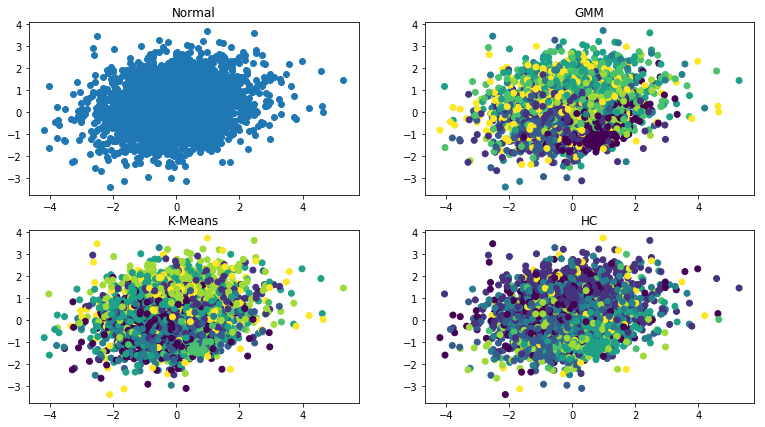

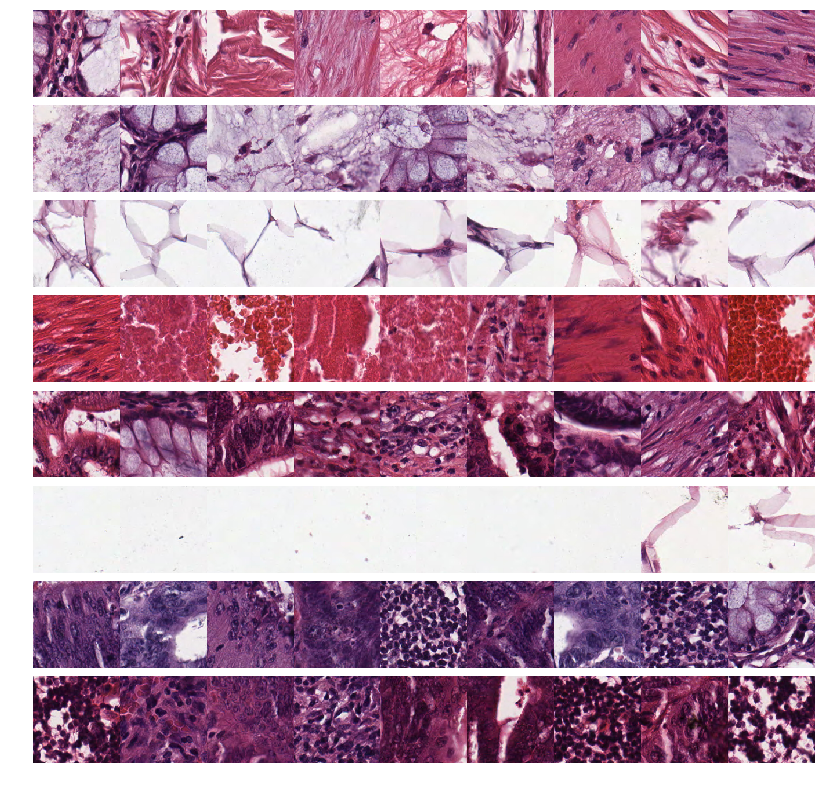

In [5]:
X = X.reshape(X.shape[0] , -1) # Reshape for scaling
X = StandardScaler().fit_transform(X) # Scale

Labels = myutils.ClusterAndPlot(8, X)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [6]:
myutils.evaluateAll3withLabels(Labels, labels_true)

GMM Adjusted Rand index 0.490446821924761
GMM homogeneity_score 0.4916514266582686
GMM adjusted_rand_score 0.364015208985086
GMM completeness_score 0.5143503686674504
GMM v_measure_score 0.4999247978018941


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/s

In [18]:
# PCA 
print(X.shape)
pca = PCA(n_components=2)
transformedData = pca.fit_transform(X)
# pca.n_components_
pca.explained_variance_ratio_

(5000, 576)


array([0.43697822, 0.14152922], dtype=float32)

(5000, 2)
HC Silhouette Score  0.3662342429161072 
kmeans Silhouette Score  0.485443115234375 
gmm Silhouette Score  0.40529507398605347 


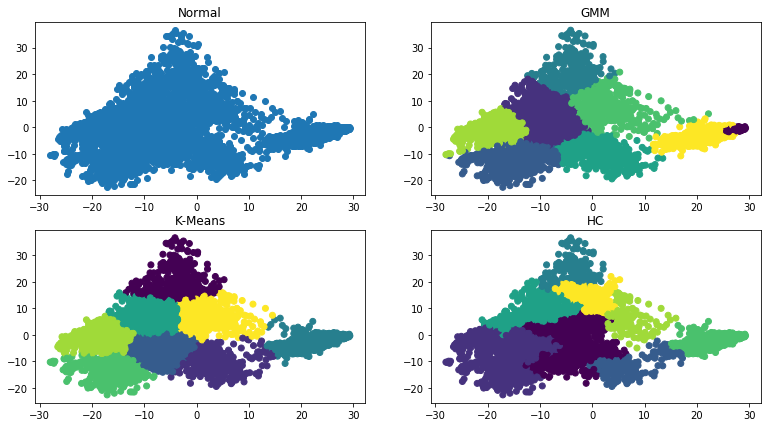

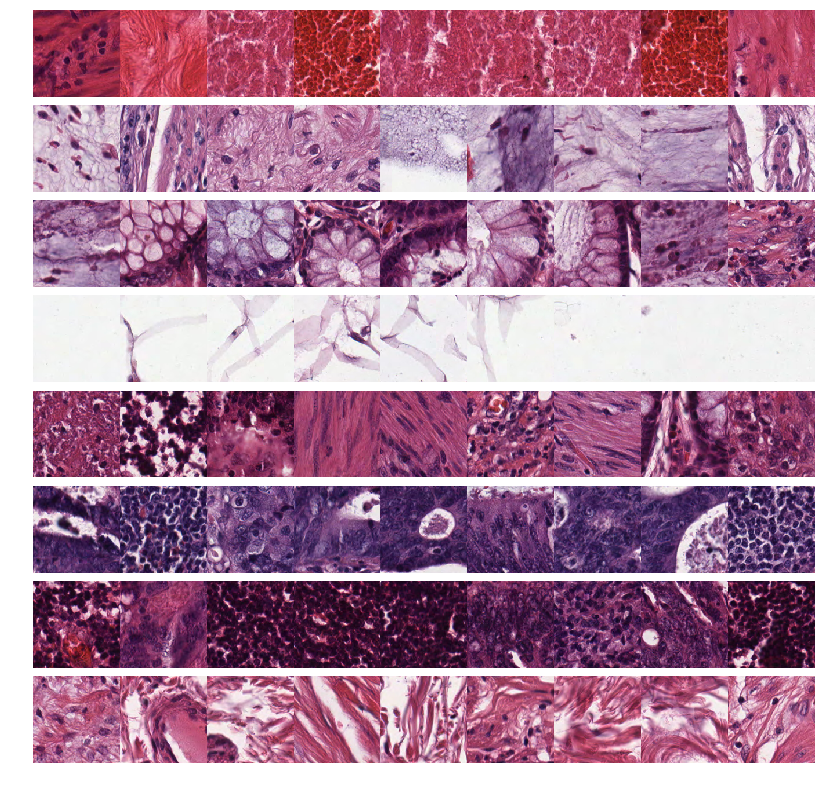

In [16]:
Labels = myutils.ClusterAndPlot(8, transformedData)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [17]:
myutils.evaluateAll3withLabels(Labels, labels_true)

GMM Adjusted Rand index 0.5295632061925039
GMM homogeneity_score 0.5306751061890984
GMM adjusted_rand_score 0.3944850418681872
GMM completeness_score 0.5452767657136722
GMM v_measure_score 0.536058156026245


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/cluster/s

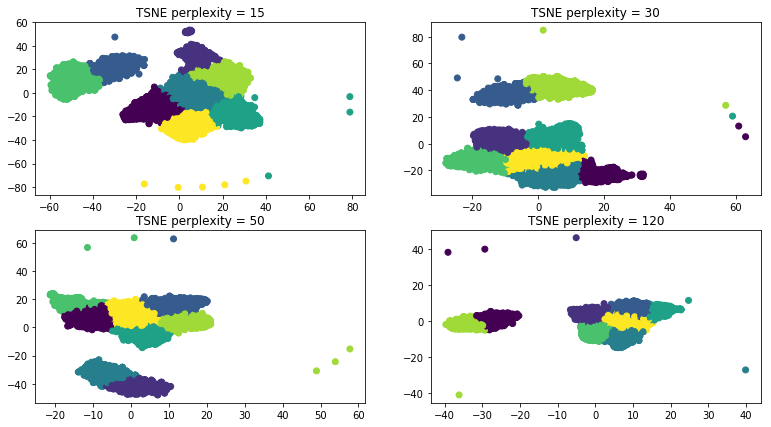

In [10]:
myutils.plotdiffTsne(transformedData)

Silhouette Score  0.32577070593833923 
Silhouette Score  0.40464913845062256 
Silhouette Score  0.24618087708950043 
Silhouette Score  0.3942194879055023 


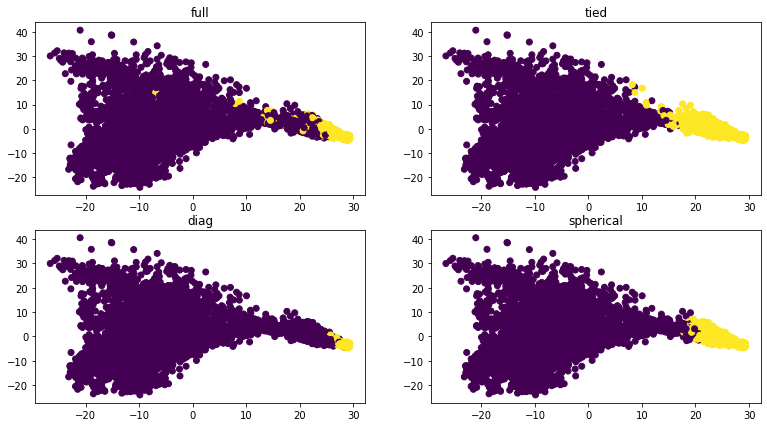

In [15]:
plotdiffGaussians(n_clusters=8, transformedData)

Silhouette Score  0.24176287651062012 
Silhouette Score  0.11372072249650955 
Silhouette Score  0.39288491010665894 
Silhouette Score  0.21448367834091187 


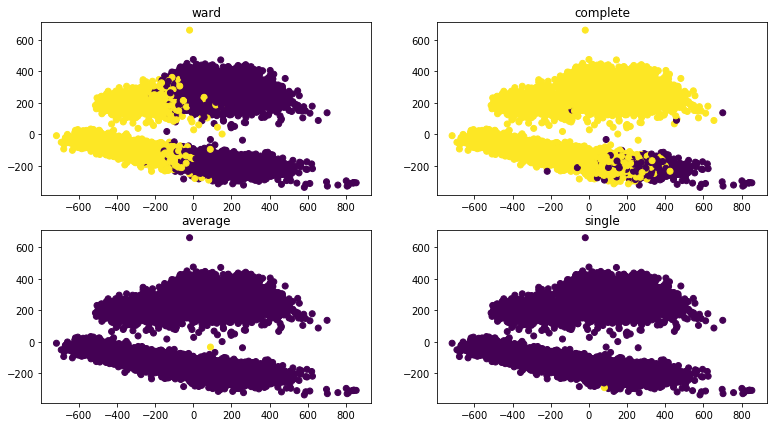

In [18]:
plotdiffHCs(n_clusters=8, transformedData)